In [1]:
from dataclasses import dataclass
from observer import CalibratedObserver, TrackedObject, CalibratedCaptureConfiguration
import dma.MechaCombat as mc
from dma.MechaCombat import GameEvent
QuantumSystem = mc.QuantumSystem
qs = QuantumSystem

In [2]:
@dataclass
class HarmonyObject(TrackedObject):
    rsc: object
    objectType: str = None
    objectSubType: str = None
    objectKwargs: dict = None

    objectFactories = {"Mech": mc.MechFactories, "Structure": mc.StructureFactories}
    
    def __post_init__(self):
        super().__post_init__(self)
        try:
            factory = self.objectFactories[self.objectType][self.objectSubType]
        except KeyError as ke:
            raise Exception(f"Unrecognized object type and subtype - {objectType}-{objectSubType}")
        factory(self.oid, **objectKwargs)

    @classmethod
    def from_tracked_object(cls,
                            trackedObject: TrackedObject,
                            objectType: str,
                            objectSubType: str,
                            objectKwargs: dict):

        if qs.entity_exists(trackedObject.oid):
            harmonyObject = cls(trackedObject.changeSet, objectType, objectSubType, objectKwargs)
            harmonyObject.oid = trackedObject.oid
            return harmonyObject
        else:
            return cls(trackedObject.changeSet, objectType, objectSubType, objectKwargs)


    def take_action(self, target, result=None):
        return ObjectAction(self, self.rsc, target, result=result, rsc=self.rsc)

In [3]:
@dataclass
class ObjectAction:
    actor: HarmonyObject
    target: HarmonyObject
    rsc: object
    result: object = None
    
    # ARCH: How to get `distanceBetweenObjects` function from app
    def __post_init__(self, obj, target, result=None):
        self.rsc = rsc
        self.cap = cap
        self.target = target
        self.targetDistance = self.rsc.distanceBetweenObjects(self.cap, self.target)
        self.targetRange = "short" if targetDistance < 155 else "medium" if targetDistance < 610 else "long"
        self.rangeModifier = 0 if "short" else 2 if "medium" else 4

        self.objMovement = self.rsc.trackedObjectLastDistance(cap)
        self.aMM = -1 if objMovement is None or objMovement < 10 else 1
        self.targetMovement = app.cm.cc.rsc.trackedObjectLastDistance(target)
        self.tMM = -1 if targetMovement is None or targetMovement < 10 else 1
        self.targetNumber = int(cap.Skill) + aMM + tMM + 0 + rangeModifier
        self.result = result

    def to_game_event(self):
        # ARCH: How to build GameEvent?
        return GameEvent()

In [4]:
class HarmonyMachine(CalibratedObserver):
    def reset(self):
        super().reset()
        mc.GameState.reset()
        self.GameState = mc.GameState

    def classifyObject(self, objectId, objectType, objectSubType, objectKwargs):
        trackedObject = self.findObject(objectId)
        memoryIndex = self.memory.index(trackedObject)
        harmonyObject = HarmonyObject.from_tracked_object(
            trackedObject, objectType, objectSubType, objectKwargs)
        self.memory[memoryIndex] = harmonyObject

    def declareEvent(self, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventResult: str):
        mc.GameState.declareEvent(eventType, eventFaction, eventObject, eventValue, eventResult)

Starting Cycle     0 -- CapMac -- passive idle


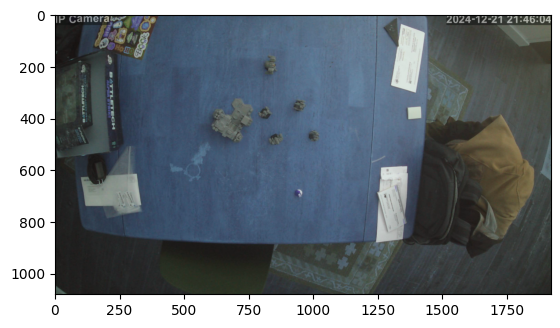

In [5]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = CalibratedCaptureConfiguration()
    hm = HarmonyMachine(cc)
    hm.cycle()
    plt.imshow(cc.cameras['0'].mostRecentFrame)

Starting Cycle     1 -- CapMac -- track idle
Starting Cycle     2 -- CapMac -- track idle
Starting Cycle     3 -- CapMac -- track idle
Starting Cycle     4 -- CapMac -- track idle
Starting Cycle     5 -- CapMac -- track idle
Starting Cycle     6 -- CapMac -- track idle
Starting Cycle     7 -- CapMac -- track idle
Starting Cycle     8 -- CapMac -- track idle
Starting Cycle     9 -- CapMac -- track idle
Starting Cycle    10 -- CapMac -- track idle
Starting Cycle    11 -- CapMac -- track idle
Starting Cycle    12 -- CapMac -- track idle
Starting Cycle    13 -- CapMac -- track idle
Starting Cycle    14 -- CapMac -- track idle
Starting Cycle    15 -- CapMac -- track idle
Starting Cycle    16 -- CapMac -- track unstable
Starting Cycle    17 -- CapMac -- track unstable
Starting Cycle    18 -- CapMac -- track unstable
Starting Cycle    19 -- CapMac -- track classify
New Memory
Starting Cycle    20 -- CapMac -- idle idle
Starting Cycle    21 -- CapMac -- idle idle
Starting Cycle    22 -- CapMac

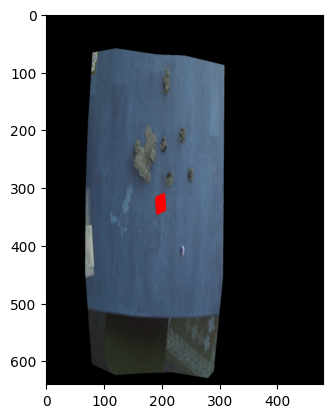

In [6]:
if __name__ == "__main__":
    for i in range(1):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()
    plt.imshow(hm.getCameraImagesWithChanges()['0'])